# Muhammad Asghar 
# Applications of NL(X) and Large Language Models
# Assignment 1: Stock Price Prediction and GameStop Short Squeeze

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN, Activation, Dropout, Reshape, Conv1D
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus.reader.wordnet import NOUN
from nltk.corpus import wordnet
from wordcloud import WordCloud
from scipy import stats
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import math
import tqdm
import spacy
import nltk
import os
import re

2024-02-17 12:30:19.902807: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/asghar/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Data from Yahoo Finance from 01/04/21 - 12/31/21
# https://finance.yahoo.com/quote/GME/history/
df = pd.read_csv("dataverse_files/GME.csv")

In [3]:
df.shape

(251, 7)

In [4]:
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,4.7500,4.7750,4.2875,4.3125,4.3125,40090000
1,2021-01-05,4.3375,4.5200,4.3075,4.3425,4.3425,19846000
2,2021-01-06,4.3350,4.7450,4.3325,4.5900,4.5900,24224800
3,2021-01-07,4.6175,4.8625,4.5050,4.5200,4.5200,24517200
4,2021-01-08,4.5450,4.5750,4.2700,4.4225,4.4225,25928000
5,2021-01-11,4.8525,5.1625,4.7525,4.9850,4.9850,59632000
6,2021-01-12,4.9900,5.1000,4.8300,4.9875,4.9875,28242800
7,2021-01-13,5.1050,9.6625,5.0075,7.8500,7.8500,578006800
8,2021-01-14,9.5225,10.7650,8.2625,9.9775,9.9775,374869600
9,2021-01-15,9.6225,10.1875,8.5025,8.8750,8.8750,187465600


In [5]:
df.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume
241,2021-12-16,38.232498,38.610001,35.532501,36.147499,36.147499,8659200
242,2021-12-17,35.937500,39.642502,34.832500,38.910000,38.910000,17226800
243,2021-12-20,38.297501,39.919998,37.424999,39.285000,39.285000,7314400
244,2021-12-21,39.264999,40.062500,38.785000,39.529999,39.529999,5720800
245,2021-12-22,39.582500,39.787498,38.029999,38.500000,38.500000,4188800
246,2021-12-23,38.500000,38.750000,36.505001,38.035000,38.035000,4222000
247,2021-12-27,38.000000,38.154999,35.000000,37.077499,37.077499,6454400
248,2021-12-28,36.875000,39.352501,36.602501,36.615002,36.615002,5324400
249,2021-12-29,36.962502,38.872501,35.535000,38.482498,38.482498,8149600
250,2021-12-30,37.750000,40.000000,37.500000,38.832500,38.832500,6247600


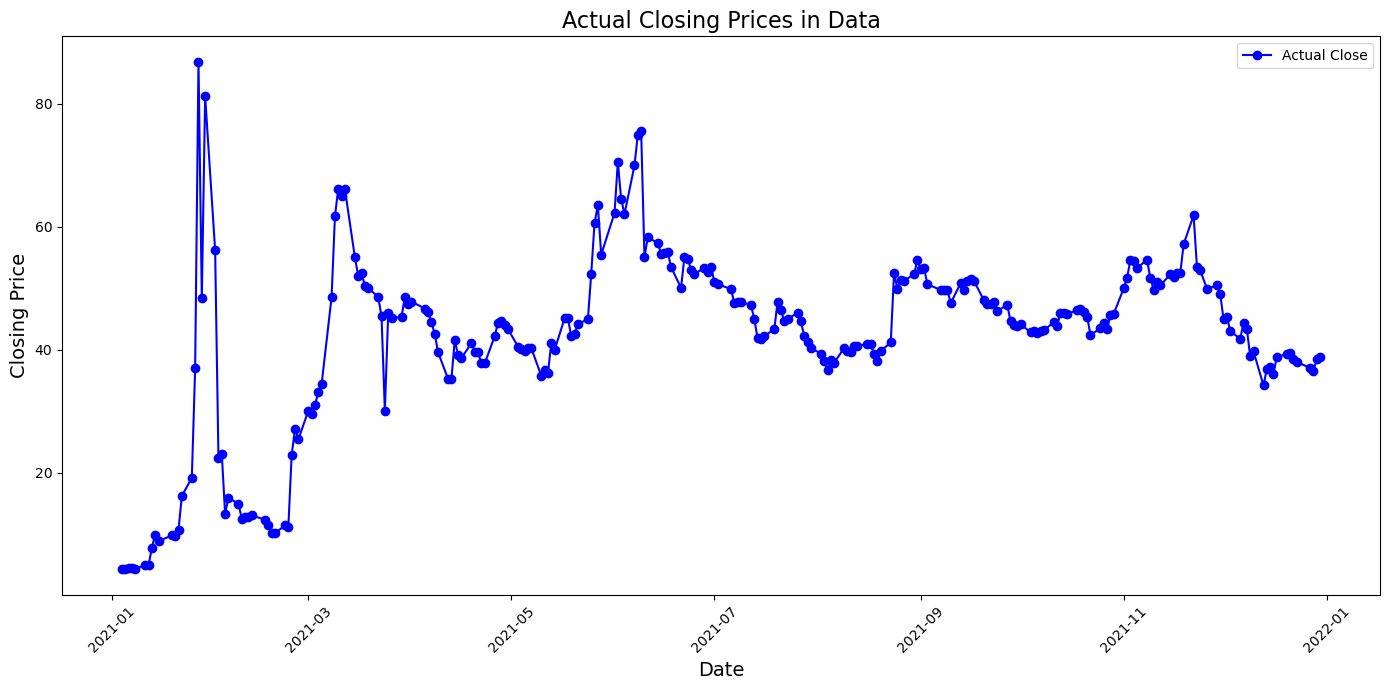

In [6]:
# Ensure the 'Date' column is in datetime format for proper plotting
df['Date'] = pd.to_datetime(df['Date'])

# Setting the plot size for better readability
plt.figure(figsize=(14, 7))

# Plotting the actual closing prices in the training period
plt.plot(df['Date'], df['Close'], label='Actual Close', color='blue', marker='o')

# Adding title and labels with font size adjustments
plt.title('Actual Closing Prices in Data', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish the actual values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Open and Close Prices')

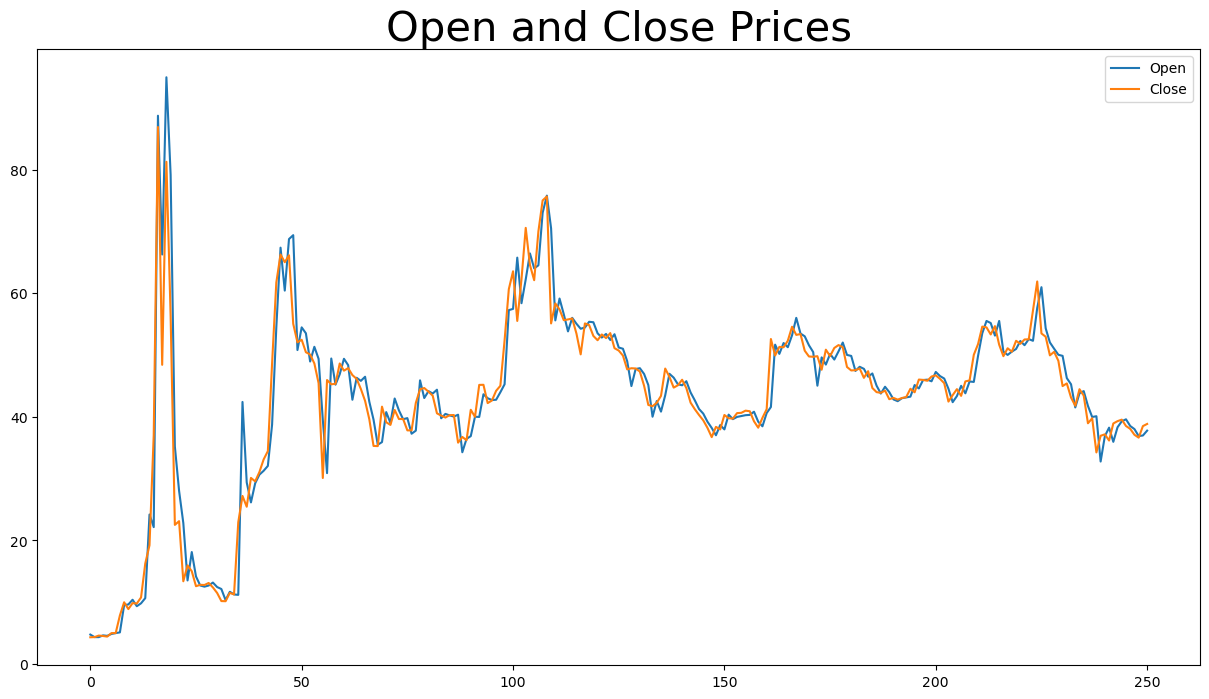

In [7]:
plt.figure(figsize = (15,8))
plt.plot(df['Open'])
plt.plot(df['Close'])
plt.legend(['Open','Close'])
plt.title('Open and Close Prices', fontsize = 30)

Text(0.5, 1.0, 'High and Low Price')

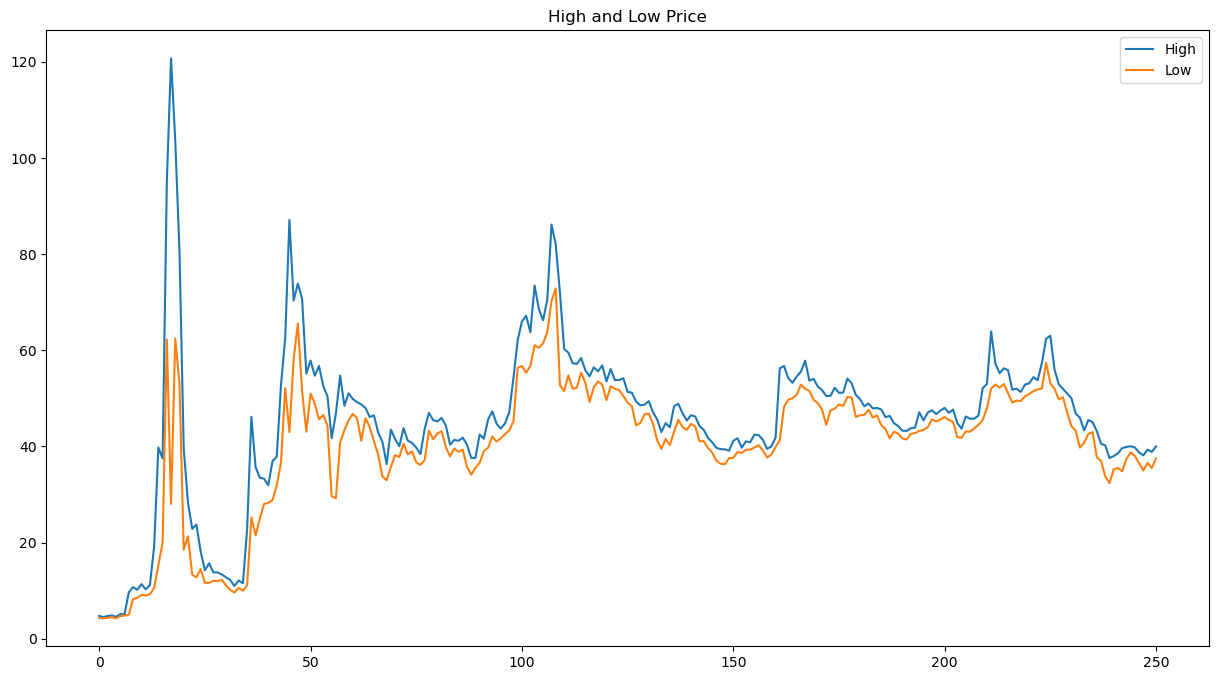

In [8]:
plt.figure(figsize = (15,8))
plt.plot(df['High'])
plt.plot(df['Low'])
plt.legend(['High','Low'])
plt.title('High and Low Price')

In [9]:
# Get Relative Strength Index
def get_RSI(df, column = 'Adj Close', time_window = 14):
    # Return the RSI indicator for the specified time window

    diff = df[column].diff(1)

    # This preservers dimensions off diff values. 
    up_chg = 0 * diff
    down_chg = 0 * diff

    # Up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff >0] = diff[diff > 0]

    # Down change is equal to negative difference, otherwise equal to zero
    down_chg[diff < 0] = diff[diff <0]

    # We set com = time_window-1 so we get decay alpha =1/time_window.
    up_chg_avg = up_chg.ewm(com=time_window -1,min_periods = time_window).mean()
    down_chg_avg = down_chg.ewm(com = time_window -1, min_periods = time_window).mean()

    RS = abs(up_chg_avg/down_chg_avg)
    df['RSI'] = 100 - 100 / (1 + RS)

    return df

In [10]:
get_RSI(df)

,Date,Open,High,Low,Close,Adj Close,Volume,RSI
0,2021-01-04,4.750000,4.775000,4.287500,4.312500,4.312500,40090000,NaN
1,2021-01-05,4.337500,4.520000,4.307500,4.342500,4.342500,19846000,NaN
2,2021-01-06,4.335000,4.745000,4.332500,4.590000,4.590000,24224800,NaN
3,2021-01-07,4.617500,4.862500,4.505000,4.520000,4.520000,24517200,NaN
4,2021-01-08,4.545000,4.575000,4.270000,4.422500,4.422500,25928000,NaN
...,...,...,...,...,...,...,...,...
246,2021-12-23,38.500000,38.750000,36.505001,38.035000,38.035000,4222000,39.694130
247,2021-12-27,38.000000,38.154999,35.000000,37.077499,37.077499,6454400,38.064750
248,2021-12-28,36.875000,39.352501,36.602501,36.615002,36.615002,5324400,37.268962
249,2021-12-29,36.962502,38.872501,35.535000,38.482498,38.482498,8149600,42.496579


Text(0.5, 1.0, 'Relative Strength Index')

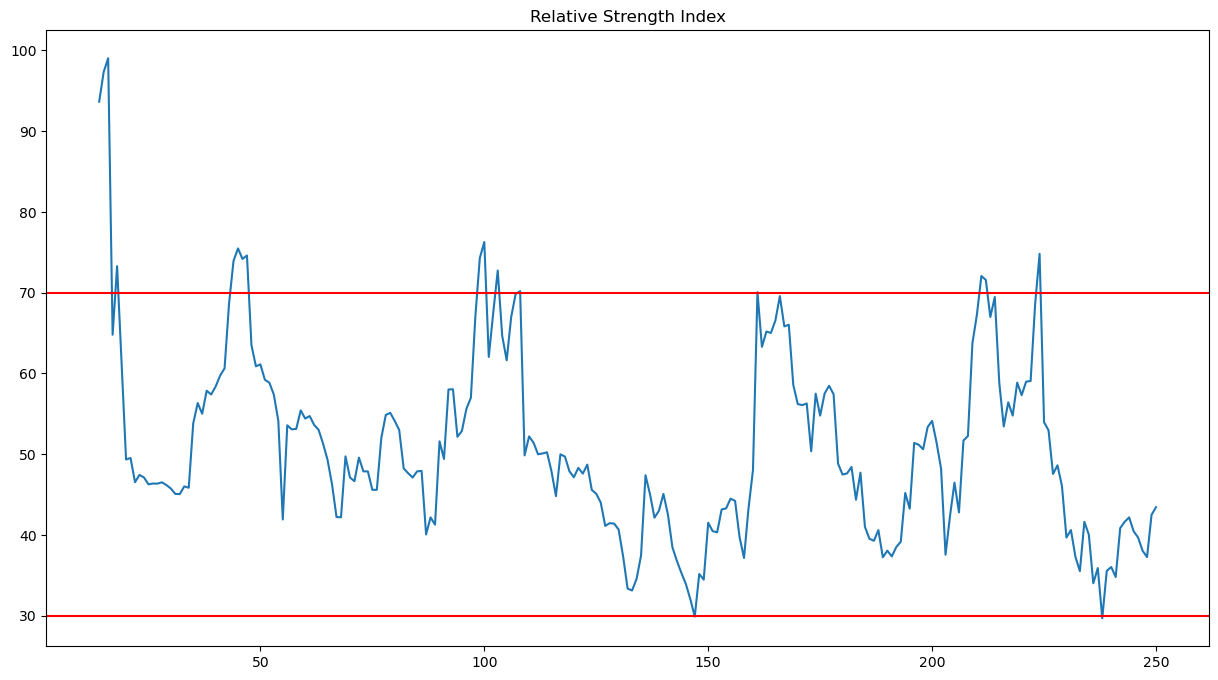

In [11]:
plt.figure(figsize = (15,8))
plt.plot(df['RSI'])
plt.axhline(y = 70,color = 'red')
plt.axhline(y = 30,color = 'red')
plt.title('Relative Strength Index')

## Time Series Forecasting -- RNN

In [12]:
df = df.Close.values.reshape(-1,1)

In [13]:
train_recs = int(len(df)*0.80)
train_data = df[:train_recs]
test_data = df[train_recs:]

len(train_data), len(test_data)

(200, 51)

In [14]:
# train_data = df[df['Date'] <= '2021-05-31']
# test_data = df[df['Date'] > '2021-05-31']

# len(train_data), len(test_data)

In [15]:
# train_data = train_data.Close.values.reshape(-1,1)
# test_data = test_data.Close.values.reshape(-1,1)

In [16]:
# Scale and train the test data
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

In [17]:
# Get the lookback for the train and test 
def get_lookback(inp, look_back):
  y = pd.DataFrame(inp)
  dataX = [y.shift(i) for i in range(1, look_back+1)]
  dataX = pd.concat(dataX, axis=1)
  dataX.fillna(0, inplace = True)
  return dataX.values, y.values

In [18]:
look_back = 10
trainX, trainY = get_lookback(train_scaled, look_back=look_back)
testX, testY = get_lookback(test_scaled, look_back= look_back)
trainX.shape, testX.shape

((200, 10), (51, 10))

In [19]:
# Build the RNN model
model = Sequential()

model.add(Reshape((look_back,1),input_shape=(look_back,)))
model.add(Conv1D(5, 3, activation='relu'))
model.add(SimpleRNN(32))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 10, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 8, 5)              20        
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1216      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 1,269
Trainable params: 1,269
Non-trainabl

In [20]:
# Compile and fit the data
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(trainX, trainY, epochs=100, batch_size=18, verbose=2, validation_split=0.1)

Epoch 1/100
10/10 - 2s - loss: 0.2600 - val_loss: 0.0055 - 2s/epoch - 180ms/step
Epoch 2/100
10/10 - 0s - loss: 0.0375 - val_loss: 0.0205 - 47ms/epoch - 5ms/step
Epoch 3/100
10/10 - 0s - loss: 0.0289 - val_loss: 0.0040 - 51ms/epoch - 5ms/step
Epoch 4/100
10/10 - 0s - loss: 0.0216 - val_loss: 0.0022 - 59ms/epoch - 6ms/step
Epoch 5/100
10/10 - 0s - loss: 0.0162 - val_loss: 0.0012 - 67ms/epoch - 7ms/step
Epoch 6/100
10/10 - 0s - loss: 0.0160 - val_loss: 6.4588e-04 - 57ms/epoch - 6ms/step
Epoch 7/100
10/10 - 0s - loss: 0.0113 - val_loss: 7.9682e-04 - 60ms/epoch - 6ms/step
Epoch 8/100
10/10 - 0s - loss: 0.0136 - val_loss: 1.8590e-04 - 55ms/epoch - 5ms/step
Epoch 9/100
10/10 - 0s - loss: 0.0138 - val_loss: 8.2385e-04 - 52ms/epoch - 5ms/step
Epoch 10/100
10/10 - 0s - loss: 0.0114 - val_loss: 1.4463e-04 - 45ms/epoch - 5ms/step
Epoch 11/100
10/10 - 0s - loss: 0.0093 - val_loss: 1.4670e-04 - 60ms/epoch - 6ms/step
Epoch 12/100
10/10 - 0s - loss: 0.0121 - val_loss: 1.2665e-04 - 49ms/epoch - 5ms/st

In [21]:
# Get the RSME
def get_model_perf(model_obj):
  score_train = model_obj.evaluate(trainX, trainY, verbose=0)
  train_mae = np.mean(np.abs(model.predict(trainX) - trainY))
  print('Train MAE: ', train_mae)
  print('Train RMSE:', (math.sqrt(score_train)))
  print('Train MSE: ', score_train)
    
  score_test = model_obj.evaluate(testX, testY, verbose=0)
  test_mae = np.mean(np.abs(model.predict(testX) - testY))
  print('Test MAE: ', test_mae)
  print('Test RMSE: ', (math.sqrt(score_test)))
  print('Test MSE: ', score_train)

get_model_perf(model)

7/7 [==============================] - 0s 2ms/step
Train MAE:  0.04348661922842336
Train RMSE: 0.07065859361724079
Train MSE:  0.004992636851966381
2/2 [==============================] - 0s 3ms/step
Test MAE:  0.05081009387202799
Test RMSE:  0.0912408934745676
Test MSE:  0.004992636851966381


2/2 [==============================] - 0s 3ms/step


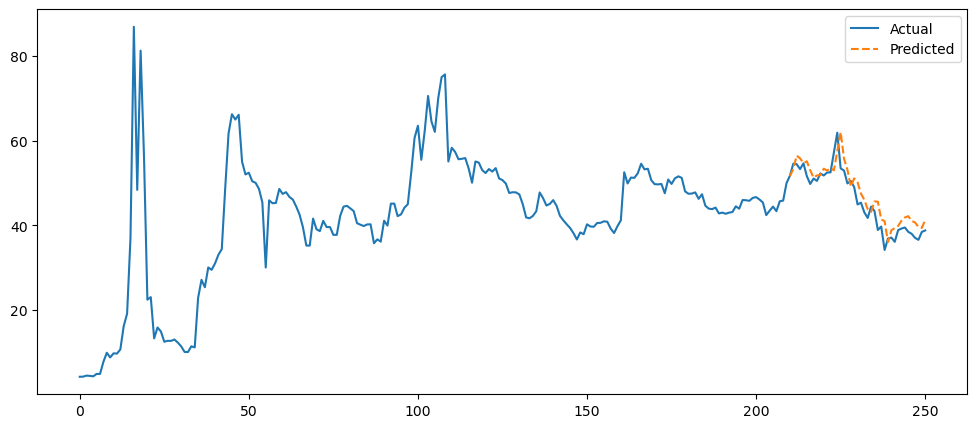

In [22]:
# Plot the predictions
def plot_pred(model_obj):
  testPredict = scaler.inverse_transform(model_obj.predict(testX))
  pred_test_plot = df.copy()
  pred_test_plot[:train_recs+look_back,:] = np.nan
  pred_test_plot[train_recs+look_back:,:] = testPredict[look_back:]
  plt.plot(df, label='Actual')
  plt.plot(pred_test_plot, "--", label='Predicted')
  plt.legend()

def plot_pred_zoom(model_obj):
  testPredict = scaler.inverse_transform(model_obj.predict(testX))
  pred_test_plot = testPredict
  plt.plot(df[train_recs:], label='Actual')
  plt.plot(pred_test_plot, "--", label='Predicted')
  plt.legend()

plt.figure(figsize=[12,5])
plot_pred(model)

2/2 [==============================] - 0s 3ms/step


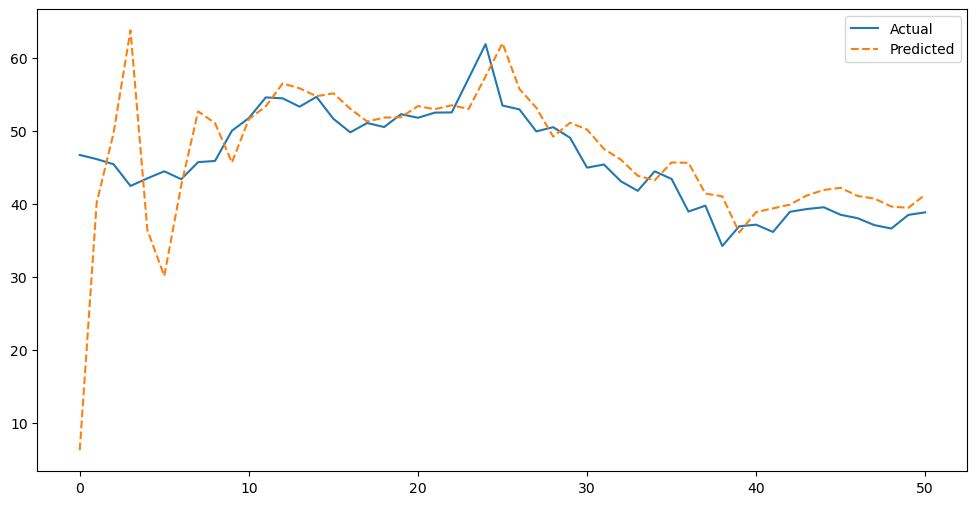

In [23]:
# Zoomed in view
plt.figure(figsize=[12,6])
plot_pred_zoom(model)

## Time Series Forecasting -- LSTM

In [24]:
# Data from Yahoo Finance from 01/04/21 - 12/31/21
# https://finance.yahoo.com/quote/GME/history/
df = pd.read_csv("dataverse_files/GME.csv")

In [25]:
df = df[['Date', 'Close']]

In [26]:
df = df.drop('Date', axis=1)
df = df.reset_index(drop=True)

In [27]:
T = df.values
T = T.astype('float32')

T = T[~np.isnan(T)]
T = np.reshape(T, (-1, 1))

scaler = MinMaxScaler(feature_range=(0, 1))
T = scaler.fit_transform(T)

In [28]:
train_size = int(len(T)*0.8)
test_size = int(len(T)-train_size)
train = T[0:train_size, :]
test = T[train_size: , :]

In [29]:
# Method for creating features for the time series data
def create_features(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size - 1):
        window = data[i:(i + window_size), 0]
        X.append(window)
        Y.append(data[i + window_size, 0])
    return np.array(X), np.array(Y)

In [30]:
#Assuming 5 trading days per week
window_size = 20
trainX, trainY = create_features(train, window_size)
testX, testY = create_features(test, window_size)

#Reshaping to the format of [samples, time steps, features] (the format that LSTM needs)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [31]:
trainY.size

179

In [32]:
testY.size

30

In [33]:
#Building model
model = Sequential()

model.add(LSTM(units=50, activation='relu', input_shape=(trainX.shape[1], window_size)))
model.add(Dropout(0.2))

model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

In [34]:
os.system("mkdir GME1")
filepath = './GME1/model_epoch_{epoch:02d}.hdf5'

checkpoint = ModelCheckpoint(filepath = filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
history = model.fit(trainX, trainY, epochs=300, batch_size=80, validation_data=(testX, testY),
                   callbacks=[checkpoint], verbose=1, shuffle=False)

model.summary()

Epoch 1/300


mkdir: GME1: File exists


1/3 [=========>....................] - ETA: 3s - loss: 0.1926
Epoch 1: val_loss improved from inf to 0.18945, saving model to ./GME1/model_epoch_01.hdf5
3/3 [==============================] - 2s 187ms/step - loss: 0.2378 - val_loss: 0.1895
Epoch 2/300
1/3 [=========>....................] - ETA: 0s - loss: 0.1601
Epoch 2: val_loss improved from 0.18945 to 0.14544, saving model to ./GME1/model_epoch_02.hdf5
3/3 [==============================] - 0s 30ms/step - loss: 0.1949 - val_loss: 0.1454
Epoch 3/300
1/3 [=========>....................] - ETA: 0s - loss: 0.1321
Epoch 3: val_loss improved from 0.14544 to 0.10818, saving model to ./GME1/model_epoch_03.hdf5
3/3 [==============================] - 0s 28ms/step - loss: 0.1561 - val_loss: 0.1082
Epoch 4/300
1/3 [=========>....................] - ETA: 0s - loss: 0.1072
Epoch 4: val_loss improved from 0.10818 to 0.07717, saving model to ./GME1/model_epoch_04.hdf5
3/3 [==============================] - 0s 27ms/step - loss: 0.1228 - val_loss: 0.

In [35]:
# I picked epoch 120 as that is when it had the most similar training and validation losses, 
# which implies that the model is not doing a lot of over or under fitting. As such, we load that model.
best_model = load_model('./GME1/model_epoch_120.hdf5')

# Predicting and inverse transforming the predictions

train_predict = best_model.predict(trainX)

trainY_hat = scaler.inverse_transform(train_predict)

test_predict = best_model.predict(testX)

testY_hat = scaler.inverse_transform(test_predict)

1/1 [==============================] - 0s 32ms/step


In [36]:
# Inverse transforming the actual values, to return them to their original values
testY = scaler.inverse_transform([testY])
trainY = scaler.inverse_transform([trainY])

In [37]:
trainY_hat = np.reshape(trainY_hat, newshape = 179)
testY_hat = np.reshape(testY_hat, newshape = 30)

trainY = np.reshape(trainY, newshape = 179)
testY = np.reshape(testY, newshape = 30)

In [38]:
def get_model_perf(model_obj):
  score_train = model_obj.evaluate(trainX, trainY, verbose=0)
  train_mae = np.mean(np.abs(model.predict(trainX) - trainY))
  print('Train MAE: ', train_mae)
  print('Train RMSE:', (math.sqrt(score_train)))
  print('Train MSE: ', score_train)
    
  score_test = model_obj.evaluate(testX, testY, verbose=0)
  test_mae = np.mean(np.abs(model.predict(testX) - testY))
  print('Test MAE: ', test_mae)
  print('Test RMSE: ', (math.sqrt(score_test)))
  print('Test MSE: ', score_train)

get_model_perf(best_model)

6/6 [==============================] - 0s 2ms/step
Train MAE:  43.29055443370084
Train RMSE: 45.003887093401445
Train MSE:  2025.349853515625
1/1 [==============================] - 0s 22ms/step
Test MAE:  43.66072848232866
Test RMSE:  44.24481067294079
Test MSE:  2025.349853515625


In [39]:
Y = np.append(trainY, testY)
Y_hat = np.append(trainY_hat, testY_hat)

In [40]:
result_df = pd.DataFrame()

result_df['Actual_Y'] = Y
result_df['Predicted_Y'] = Y_hat

result_df.head()

,Actual_Y,Predicted_Y
0,22.499999,41.715359
1,23.102501,37.385021
2,13.375000,28.366503
3,15.942499,24.731804
4,15.000000,16.502171


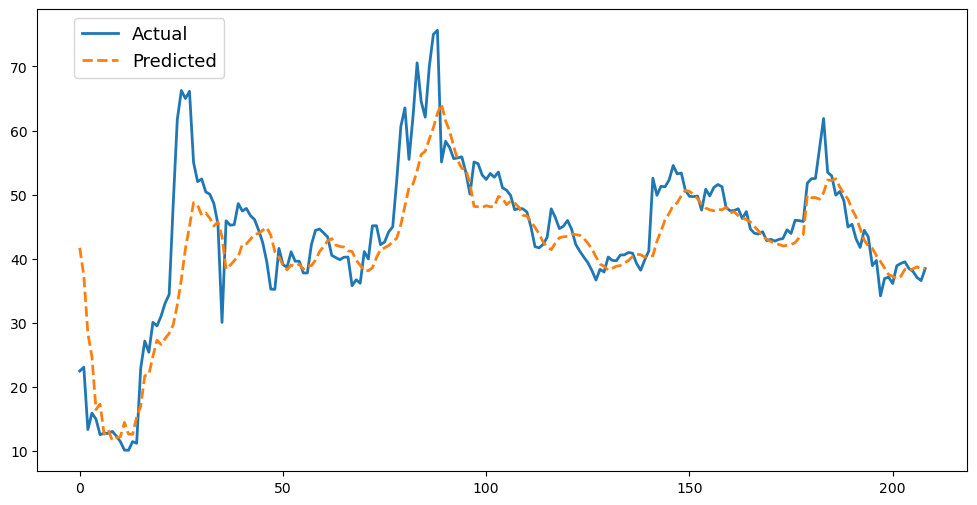

In [41]:
plt.figure(figsize = (12,6))
plt.plot(result_df["Actual_Y"], linewidth=2.0, label = "Actual")
plt.plot(result_df["Predicted_Y"], "--", linewidth=2.0, label = "Predicted")
plt.rcParams.update({'font.size': 13})
plt.legend(loc="upper left", bbox_to_anchor=(0.03, 1))
plt.show()

## Sentiment Analysis

In [42]:
features = pd.read_csv("dataverse_files/rGME_dataset_features.csv")

/var/folders/df/rc0lymgs6nvd3r8bhd0wfb880000gn/T/ipykernel_43726/2893570116.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  features = pd.read_csv("dataverse_files/rGME_dataset_features.csv")


In [43]:
features.shape

(1033236, 74)

In [44]:
features.head(5)

,Unnamed: 0,id,title,url,score,author,num_comments,date,flair,compound,...,_poss,_intj,_appos,_npadvmod,_predet,_case,_expl,_oprd,_dative,_nmod
0,0,kqfajb,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,https://www.reddit.com/r/GME/comments/kqfajb/y...,1.0,TitsDownOnly,9.0,2021-01-04,NaN,0.9872,...,0,0,6,0,0,0,0,0,0,0
1,1,kqjh2t,Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀,/r/wallstreetbets/comments/kqcwdo/gamestops_gr...,1.0,zoomermoney,1.0,2021-01-04,NaN,0.9906,...,0,0,3,0,0,0,0,0,0,0
2,2,kqvp7l,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,https://www.reddit.com/r/GME/comments/kqvp7l/t...,1.0,TitsDownOnly,6.0,2021-01-05,NaN,0.5319,...,0,0,0,0,0,0,0,0,0,0
3,3,krcwch,You already know what we must do brothers and ...,/r/wallstreetbets/comments/kr98ym/gme_gang_we_...,1.0,dontforgettolive,4.0,2021-01-05,NaN,-0.2960,...,1,0,0,0,0,0,0,0,0,0
4,4,krnthg,ICR conference (11th Jan),https://www.reddit.com/r/GME/comments/krnthg/i...,1.0,nicky94,10.0,2021-01-06,NaN,0.0000,...,0,0,0,1,0,0,0,0,0,0


In [45]:
features.columns

Index(['Unnamed: 0', 'id', 'title', 'url', 'score', 'author', 'num_comments',
       'date', 'flair', 'compound', 'neg', 'neu', 'pos', 'spacy_title',
       'clean_text', 'char_count', 'word_count', 'word_count_cln',
       'stopword_count', 'pos_tags', 'dep_tags', '_NOUN', '_VERB', '_ADP',
       '_ADJ', '_DET', '_PROPN', '_INTJ', '_PUNCT', '_NUM', '_PRON', '_ADV',
       '_PART', '_amod', '_ROOT', '_punct', '_advmod', '_auxpass',
       '_nsubjpass', '_ccomp', '_acomp', '_neg', '_nsubj', '_aux', '_agent',
       '_det', '_pobj', '_prep', '_csubj', '_nummod', '_attr', '_acl',
       '_relcl', '_dobj', '_pcomp', '_xcomp', '_cc', '_conj', '_mark', '_prt',
       '_compound', '_dep', '_advcl', '_parataxis', '_poss', '_intj', '_appos',
       '_npadvmod', '_predet', '_case', '_expl', '_oprd', '_dative', '_nmod'],
      dtype='object')

In [46]:
features['clean_text']

0                                       need GME 🚀 🚀 🚀 🚀 🚀 🚀
1                       short squeeze incoming 🚀 🚀 🚀 🚀 🚀 🚀 🚀
2                        convinced 💰 GME EXTREME PUMP COMING
3                       know brother sister submit complaint
4                                    ICR conference 11th Jan
                                 ...                        
1033231    hedgie relic past generations- place future ev...
1033232                                       Snapchat 🔥 🔥 🔥
1033233                                  moas ruin year hold
1033234                                         pattern 2022
1033235                                               GWagon
Name: clean_text, Length: 1033236, dtype: object

In [47]:
def word_cloud_barchart(method, data, column, choice, ngram_n):
    stop = stopwords.words('english')
    stop += ['gamestop', 'stop', 'xbox', 'peopl', 'got', 'go', 'ps5', 'gt', 'order']
    
    # Import the desired colormap from matplotlib
    cmap = mpl.cm.Reds(np.linspace(0,1,20)) 
    # The darker part of the matrix is selected for readability
    cmap = mpl.colors.ListedColormap(cmap[-10:,:-1]) 
    
    if method == 'Word Cloud':
        w = WordCloud(width=1600,height=1200,mode='RGBA',background_color='black',max_words=1000, colormap=cmap).fit_words(freq)
        plt.figure(figsize=(25,25))
        plt.xticks([])
        plt.yticks([])
        plt.imshow(w)
        plt.show()

In [48]:
# Most Frequent Words in the Text
word_cloud_barchart('tfid', features, 'title', 'Word Cloud', (2,4))

/Users/asghar/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/asghar/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/asghar/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


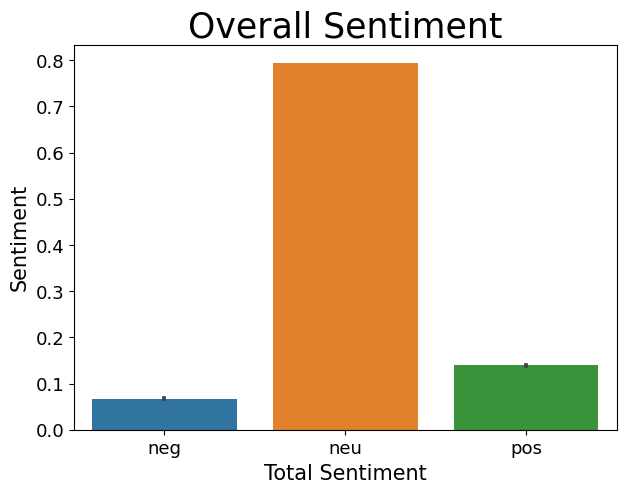

In [49]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(data=features[['neg', 'neu', 'pos']])
plt.ylabel("Sentiment", fontsize = 15)
plt.xlabel("Total Sentiment", fontsize = 15)
plt.title("Overall Sentiment", fontsize = 25)
plt.show()

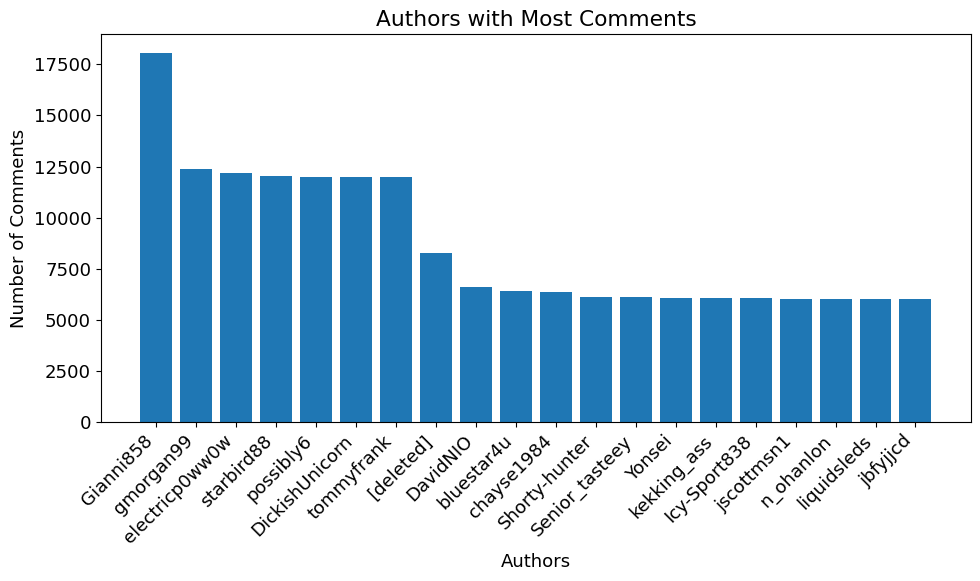

In [50]:
# Authors who commented the most
author_comments = features.groupby('author')['title'].count()
top_authors = author_comments.sort_values(ascending=False).head(20)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(top_authors.index, top_authors.values)
plt.xlabel('Authors')
plt.ylabel('Number of Comments')
plt.title('Authors with Most Comments')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

## Model fusion

In [51]:
# Load sentiment data and GME stock price data
gme_df = pd.read_csv("dataverse_files/GME.csv")  
sentiment_df = pd.read_csv("dataverse_files/rGME_dataset_features.csv")  

gme_df['Date'] = pd.to_datetime(gme_df['Date'])
sentiment_df = sentiment_df.rename(columns={'date': 'Date'})
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])

# Merge based on the 'Date' column
combined_df = pd.merge(gme_df, sentiment_df, on="Date", how="inner")

print(combined_df.head())

/var/folders/df/rc0lymgs6nvd3r8bhd0wfb880000gn/T/ipykernel_43726/1479777672.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  sentiment_df = pd.read_csv("dataverse_files/rGME_dataset_features.csv")


        Date    Open   High     Low   Close  Adj Close    Volume  Unnamed: 0  \
0 2021-01-04  4.7500  4.775  4.2875  4.3125     4.3125  40090000           0   
1 2021-01-04  4.7500  4.775  4.2875  4.3125     4.3125  40090000           1   
2 2021-01-05  4.3375  4.520  4.3075  4.3425     4.3425  19846000           2   
3 2021-01-05  4.3375  4.520  4.3075  4.3425     4.3425  19846000           3   
4 2021-01-06  4.3350  4.745  4.3325  4.5900     4.5900  24224800           4   

       id                                              title  ... _poss  \
0  kqfajb              You NEED to see this about GME 🚀🚀🚀🚀🚀🚀  ...     0   
1  kqjh2t                     Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀  ...     0   
2  kqvp7l  THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...  ...     0   
3  krcwch  You already know what we must do brothers and ...  ...     1   
4  krnthg                          ICR conference (11th Jan)  ...     0   

   _intj _appos  _npadvmod _predet  _case  _expl  _oprd  _dative _nm

In [52]:
combined_df

,Date,Open,High,Low,Close,Adj Close,Volume,Unnamed: 0,id,title,...,_poss,_intj,_appos,_npadvmod,_predet,_case,_expl,_oprd,_dative,_nmod
0,2021-01-04,4.7500,4.775,4.2875,4.3125,4.3125,40090000,0,kqfajb,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,...,0,0,6,0,0,0,0,0,0,0
1,2021-01-04,4.7500,4.775,4.2875,4.3125,4.3125,40090000,1,kqjh2t,Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀,...,0,0,3,0,0,0,0,0,0,0
2,2021-01-05,4.3375,4.520,4.3075,4.3425,4.3425,19846000,2,kqvp7l,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,...,0,0,0,0,0,0,0,0,0,0
3,2021-01-05,4.3375,4.520,4.3075,4.3425,4.3425,19846000,3,krcwch,You already know what we must do brothers and ...,...,1,0,0,0,0,0,0,0,0,0
4,2021-01-06,4.3350,4.745,4.3325,4.5900,4.5900,24224800,4,krnthg,ICR conference (11th Jan),...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
952185,2021-12-30,37.7500,40.000,37.5000,38.8325,38.8325,6247600,1033087,rskst7,Delisting 25-NSE,...,0,0,0,0,0,0,0,0,0,0
952186,2021-12-30,37.7500,40.000,37.5000,38.8325,38.8325,6247600,1033088,rskvj6,Went to a tea store and one of the fortune sti...,...,0,0,0,0,0,0,0,0,0,0
952187,2021-12-30,37.7500,40.000,37.5000,38.8325,38.8325,6247600,1033089,rslkrk,Charliesvids has switched up like the rat bast...,...,1,0,0,0,0,0,0,0,0,1
952188,2021-12-30,37.7500,40.000,37.5000,38.8325,38.8325,6247600,1033090,rsls3z,"Ryan Ξ Kagy on Twitter - ""We're not here to ru...",...,0,0,0,0,0,0,0,0,0,0


In [53]:
combined_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Unnamed: 0', 'id', 'title', 'url', 'score', 'author', 'num_comments',
       'flair', 'compound', 'neg', 'neu', 'pos', 'spacy_title', 'clean_text',
       'char_count', 'word_count', 'word_count_cln', 'stopword_count',
       'pos_tags', 'dep_tags', '_NOUN', '_VERB', '_ADP', '_ADJ', '_DET',
       '_PROPN', '_INTJ', '_PUNCT', '_NUM', '_PRON', '_ADV', '_PART', '_amod',
       '_ROOT', '_punct', '_advmod', '_auxpass', '_nsubjpass', '_ccomp',
       '_acomp', '_neg', '_nsubj', '_aux', '_agent', '_det', '_pobj', '_prep',
       '_csubj', '_nummod', '_attr', '_acl', '_relcl', '_dobj', '_pcomp',
       '_xcomp', '_cc', '_conj', '_mark', '_prt', '_compound', '_dep',
       '_advcl', '_parataxis', '_poss', '_intj', '_appos', '_npadvmod',
       '_predet', '_case', '_expl', '_oprd', '_dative', '_nmod'],
      dtype='object')

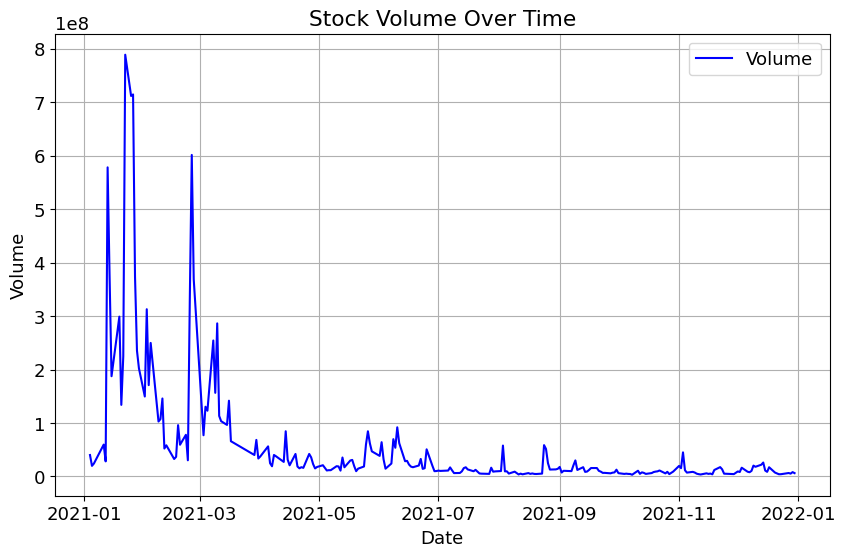

In [54]:
dates = pd.to_datetime(combined_df['Date'])
volume = combined_df['Volume']

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(dates, volume, color='b', label='Volume')
plt.title('Stock Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.legend()
plt.show()

In [55]:
# Select relevant features (stock prices and sentiment scores)
features = ['Close'] # , 'compound', 'neg', 'neu', 'pos'
data = combined_df[features]

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences
sequence_length = 20
X, y = [], []
for i in range(len(data_scaled) - sequence_length):
    X.append(data_scaled[i : i + sequence_length])
    y.append(data_scaled[i + sequence_length, 0])

X, y = np.array(X), np.array(y)

# Split into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(sequence_length, len(features))))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform to get actual prices
y_pred_actual = scaler.inverse_transform(y_pred)

/Users/asghar/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/asghar/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/asghar/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/asghar/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinsta

Epoch 1/10
23805/23805 [==============================] - 218s 9ms/step - loss: 1.4804e-04
Epoch 2/10
23805/23805 [==============================] - 203s 9ms/step - loss: 3.9750e-06
Epoch 3/10
23805/23805 [==============================] - 210s 9ms/step - loss: 2.8912e-06
Epoch 4/10
23805/23805 [==============================] - 202s 8ms/step - loss: 2.4100e-06
Epoch 5/10
23805/23805 [==============================] - 200s 8ms/step - loss: 2.3241e-06
Epoch 6/10
23805/23805 [==============================] - 209s 9ms/step - loss: 2.2285e-06
Epoch 7/10
23805/23805 [==============================] - 188s 8ms/step - loss: 2.2028e-06
Epoch 8/10
23805/23805 [==============================] - 195s 8ms/step - loss: 2.2009e-06
Epoch 9/10
23805/23805 [==============================] - 221s 9ms/step - loss: 2.1672e-06
Epoch 10/10
5952/5952 [==============================] - 29s 5ms/step


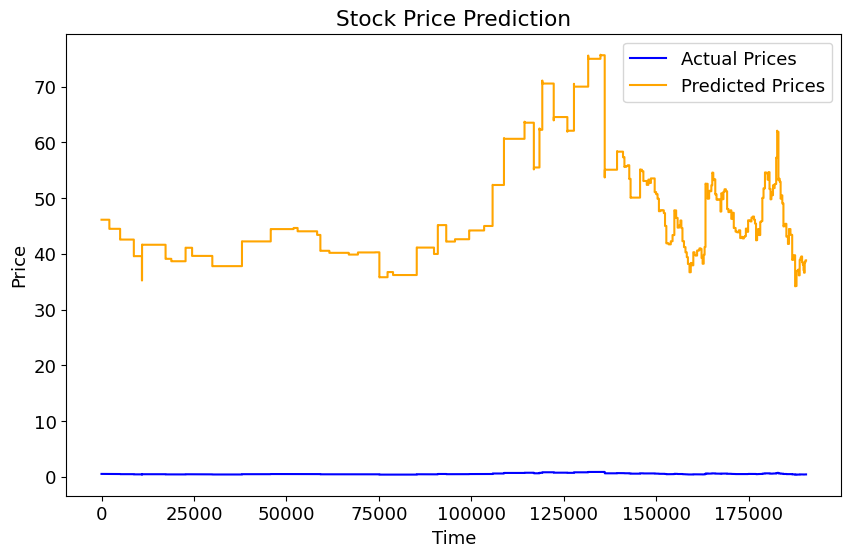

In [56]:
# Visualize results
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Prices', color='blue')
plt.plot(y_pred_actual, label='Predicted Prices', color='orange')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [57]:
# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_actual))
mse = mean_squared_error(y_test, y_pred_actual)

print("Test MAE: ", mae)
print("Test RMSE: ", rmse )
print("Test MSE: ", mse)

Test MAE:  46.2696878633634
Test RMSE:  47.21703314437294
Test MSE:  2229.448218956813
